In [1]:
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["font.family"] = "Arial Narrow"

In [3]:
import warnings

In [4]:
from scipy.stats import fisher_exact

In [5]:
import pandas as pd
import numpy as np

/tmp/ipykernel_79444/2162656668.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
import bioframe as bf

In [8]:
iscores = pd.read_csv('../../data/ComplementaryData/HiC/genomic-Insulation-Score_1-8-2.tsv', sep='\t', index_col=0)
tads = pd.read_csv('../../data/ComplementaryData/HiC/aligned_TADbit_TAD-borders.tsv', sep="\t")

In [9]:
times = ['0h', '1h', '4h', '7h', '10h', '24h', 'w24h']

In [10]:
iscores = iscores.rename(columns={'Chromosome': 'chrom', 'Start': 'start', 'End': 'end'})

### sigmoid normalization of Insulation Scores

In [11]:
for t in times:
    iscores[f'{t}'] = 1 / (1 + np.exp(-iscores[f'{t}']))

In [12]:
tads = tads.rename(columns={'Chromosome': 'chrom', 'position': 'start'})
tads['end'] = tads['start'] + 1

In [13]:
tads = tads[['chrom', 'start', 'end', 'pos_0h', 'score_0h', 'density_0h', 'IS_0h', 'pos_1h',
             'score_1h', 'density_1h', 'IS_1h', 'pos_4h', 'score_4h', 'density_4h',
             'IS_4h', 'pos_7h', 'score_7h', 'density_7h', 'IS_7h', 'pos_10h',
             'score_10h', 'density_10h', 'IS_10h', 
             'pos_24h', 'score_24h', 'density_24h', 'IS_24h',
             'pos_w24h', 'score_w24h', 'density_w24h', 'IS_w24h',
            ]]

In [14]:
bfiscores = bf.from_any(iscores)

In [15]:
reso = 50_000

In [16]:
def get_IS_profile(subtads, t, vmin=-10, vmax=10):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        bftads = bf.from_any(subtads[["chrom", "start", "end"]])

        # search for IS to the left and to the right of the border
        t_left = bf.closest (bftads, bfiscores, k=10, ignore_downstream=True)
        t_right = bf.closest(bftads, bfiscores, k=11, ignore_upstream=True)
        t_left['distance']  = (-t_left['distance']  + reso / 2) // reso
        t_right['distance'] = (t_right['distance']  + reso / 2) // reso
        # put it together
        tad = pd.concat([t_left, t_right])
        tad = tad[["chrom", 'start', 'end', f'{t}_', 'distance']]
        tad = tad.astype({"distance": int})
        ## fill missing positions with nans
        # create a column with position and distance
        tad['index'] = (tad["chrom"] + '_' + tad["start"].astype(str) + '_' + tad["end"].astype(str) + 
                  '_' + tad["distance"].astype(str))
        tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(
            {f'{t}_': np.nanmedian, 'distance': 'min'})  # lots of warning :S
        tad = tad.set_index(["index"])
        # we define the whole range of values we want to plot around each TAD border 
        vals = []
        for c, b, e in subtads[['chrom', 'start', 'end']].to_numpy():
            for i in range(-10, 11):
                vals.append(f"{c}_{b}_{e}_{i}")
        index = pd.Index(vals, name='lele')
        # assign this list to original table filling with nans
        tad = tad.reindex(index)
        # go back to original table structure
        tad['chrom'   ] = [    v.split('_')[0]  for v in tad.index]
        tad['start'   ] = [int(v.split('_')[1]) for v in tad.index]
        tad['end'     ] = [int(v.split('_')[2]) for v in tad.index]
        tad['distance'] = [int(v.split('_')[3]) for v in tad.index]
        tad = tad.reset_index()
        tad = tad[['chrom', 'start', 'end', f'{t}_', 'distance']]
        ## we now groupby TAD positions to pull together all distances
        # first we need to order to always have IS in the same order:
        tad = tad.sort_values(by='distance')
        tad = tad.groupby(['chrom', 'start', 'end'])[f'{t}_'].apply(list).reset_index(name='new')
        return np.nanmedian([l for l in tad['new'].to_list()], axis=0)


In [17]:
scores = {}
for t in times:
    print(t)
    scores[t] = get_IS_profile(tads[tads[f"score_{t}"] > 4], t)

0h


/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(


1h


/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(


4h


/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(


7h


/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(


10h


/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(


24h


/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(


w24h


/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(


## Plot Insulation Score profiles around TAD borders

In [18]:
colors = {
    '0h'  : "#fde725", 
    '1h'  : "#37b578",
    '4h'  : "#21908d",
    '7h'  : "#31668d",
    '10h' : "#43377f",
    '24h' : "#440154",
    'w24h': '#fb8524',
#     'w48h': '#00000080',
}

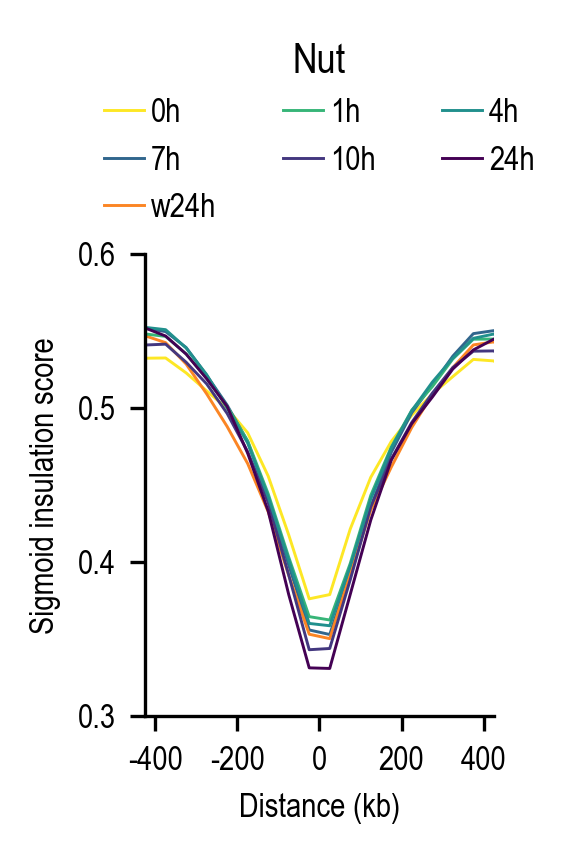

In [20]:
plt.figure(figsize = (1.5, 2), dpi=300)
ax = plt.subplot()
for t in ['0h', '7h', 'w24h', '1h', '10h', '4h', '24h']:
    ax.plot(scores[t], label=t, color=colors[t], lw=0.7)
ax.set_xticks([v + 0.5 for v in range(1, 19, 4)])
ax.set_xticklabels([f"{v * reso // 1000  - 450}" for v in range(1, 19, 4)], fontsize=8)
ax.set_xlim(1, 18)
ax.set_xlabel("Distance (kb)", fontsize=8)
ax.set_yticks([0.3, 0.4, 0.5, 0.6])
ax.set_ylabel("Sigmoid insulation score", size=8)
plt.yticks(fontsize=8)
plt.legend(frameon=False, ncol=3, bbox_to_anchor=(0.5, 1), loc='lower center',
          handlelength=1.2, columnspacing=2, handletextpad=0.2, fontsize=8, title='Nut')
ax.spines[['right', 'top']].set_visible(False)
# plt.savefig('Insulation_profile.pdf', dpi=300)
# plt.savefig('Insulation_profile.png', dpi=300)

### Insulation Score profiles by TAD border conservation type

In [21]:
conserved = tads[(tads['score_0h'] > 4) & (tads['score_1h'] > 4) & (tads['score_4h'] > 4) & 
     (tads['score_7h'] > 4) & (tads['score_10h'] > 4) & (tads['score_24h'] > 4)]

In [22]:
conserved_scores = {}
for t in times:
    print(t)
    conserved_scores[t] = get_IS_profile(conserved[conserved[f"score_{t}"] > 4], t)

0h
1h


/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(
/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(


4h
7h


/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(
/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(


10h
24h


/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(
/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(


w24h


/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(


In [24]:
variable = tads[~(tads['score_0h'] > 4) | ~(tads['score_1h'] > 4) | ~(tads['score_4h'] > 4) |
     ~(tads['score_7h'] > 4) | ~(tads['score_10h'] > 4) | ~(tads['score_24h'] > 4)]

In [25]:
variable_scores = {}
for t in times:
    print(t)
    variable_scores[t] = get_IS_profile(variable[variable[f"score_{t}"] > 4], t)

0h
1h


/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(
/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(


4h
7h


/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(
/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(


10h
24h


/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(
/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(


w24h


/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(


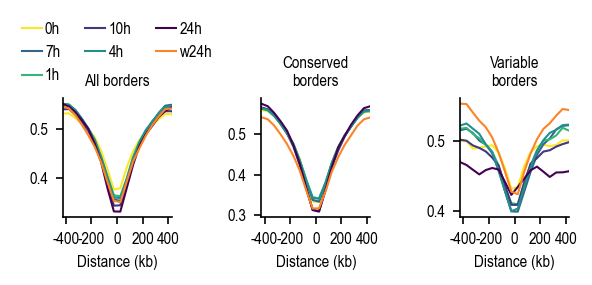

In [26]:
plt.figure(figsize = (4, 2), dpi=150)
ax = plt.subplot(1, 3, 1)
for t in ['0h', '7h', '1h', '10h', '4h', '24h', 'w24h']:
    ax.plot(scores[t], label=t, color=colors[t], lw=1)
ax.set_xticks([v + 0.5 for v in range(1, 19, 4)])
ax.set_xticklabels([f"{v * reso // 1000  - 450}" for v in range(1, 19, 4)], fontsize=8)
ax.set_xlim(1, 18)
ax.set_xlabel("Distance (kb)", fontsize=8)
plt.yticks(fontsize=8)
plt.legend(frameon=False, ncol=3, bbox_to_anchor=(0.5, 1), loc='lower center',
          handlelength=1.2, columnspacing=1.5, handletextpad=0.2, fontsize=8)
plt.title('All borders', size=8)
ax.spines[['right', 'top']].set_visible(False)

ax = plt.subplot(1, 3, 2)
for t in ['0h', '7h', '1h', '10h', '4h', '24h', 'w24h']:
    ax.plot(conserved_scores[t], label=t, color=colors[t], lw=1)
ax.set_xticks([v + 0.5 for v in range(1, 19, 4)])
ax.set_xticklabels([f"{v * reso // 1000  - 450}" for v in range(1, 19, 4)], fontsize=8)
ax.set_xlim(1, 18)
ax.set_xlabel("Distance (kb)", fontsize=8)
plt.title('Conserved\nborders', size=8)
plt.yticks(fontsize=8)
ax.spines[['right', 'top']].set_visible(False)

ax = plt.subplot(1, 3, 3)
for t in ['0h', '7h', '1h', '10h', '4h', '24h', 'w24h']:
    ax.plot(variable_scores[t], label=t, color=colors[t], lw=1)
ax.set_xticks([v + 0.5 for v in range(1, 19, 4)])
ax.set_xticklabels([f"{v * reso // 1000  - 450}" for v in range(1, 19, 4)], fontsize=8)
ax.set_xlim(1, 18)
ax.set_xlabel("Distance (kb)", fontsize=8)
plt.yticks(fontsize=8)
plt.title('Variable\nborders', size=8)
ax.spines[['right', 'top']].set_visible(False)

plt.tight_layout()


In [27]:
lost1h = get_IS_profile(tads[(tads['score_0h'] > 4) & ~(tads['score_1h'] > 4)], '0h')
len(tads[(tads['score_0h'] > 4) & ~(tads['score_1h'] > 4)])

/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(


1010

In [28]:
lost24h = get_IS_profile(tads[(tads['score_10h'] > 4) & ~(tads['score_24h'] > 4)], '10h')
len(tads[(tads['score_10h'] > 4) & ~(tads['score_24h'] > 4)])

/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(


1019

In [29]:
gain1h = get_IS_profile(tads[~(tads['score_0h'] > 4) & (tads['score_1h'] > 4)], '1h')
len(tads[~(tads['score_0h'] > 4) & (tads['score_1h'] > 4)])

/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(


234

In [30]:
gain10h = get_IS_profile(tads[~(tads['score_7h'] > 4) & (tads['score_10h'] > 4)], '10h')
len(tads[~(tads['score_7h'] > 4) & (tads['score_10h'] > 4)])

/tmp/ipykernel_79444/2636260728.py:19: FutureWarning: The provided callable <function nanmedian at 0x7f4278196160> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tad = tad.groupby(by=['chrom', 'start', 'end', 'index'], as_index=False).agg(


621

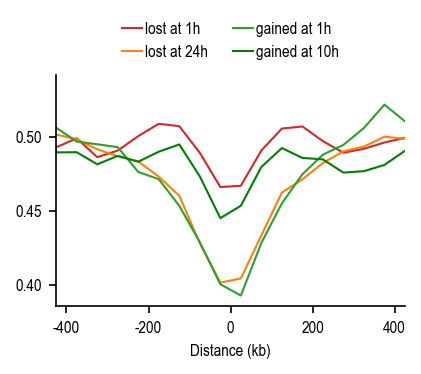

In [31]:
plt.figure(figsize=(3, 2), dpi=150)
ax = plt.subplot()
plt.plot(lost1h , lw=1, label='lost at 1h', color='tab:red')
plt.plot(lost24h, lw=1, label='lost at 24h', color='tab:orange')
plt.plot(gain1h , lw=1, label='gained at 1h', color='tab:green')
plt.plot(gain10h, lw=1, label='gained at 10h', color='green')
ax.set_xticks([v + 0.5 for v in range(1, 19, 4)])
ax.set_xticklabels([f"{v * reso // 1000  - 450}" for v in range(1, 19, 4)], fontsize=8)
ax.set_xlim(1, 18)
ax.set_xlabel("Distance (kb)", fontsize=8)
plt.yticks(fontsize=8)
plt.legend(frameon=False, ncol=2, bbox_to_anchor=(0.5, 1), loc='lower center',
          handlelength=1.2, columnspacing=1.5, handletextpad=0.2, fontsize=8)
ax.spines[['right', 'top']].set_visible(False)


### Insulation profiles uppon changes

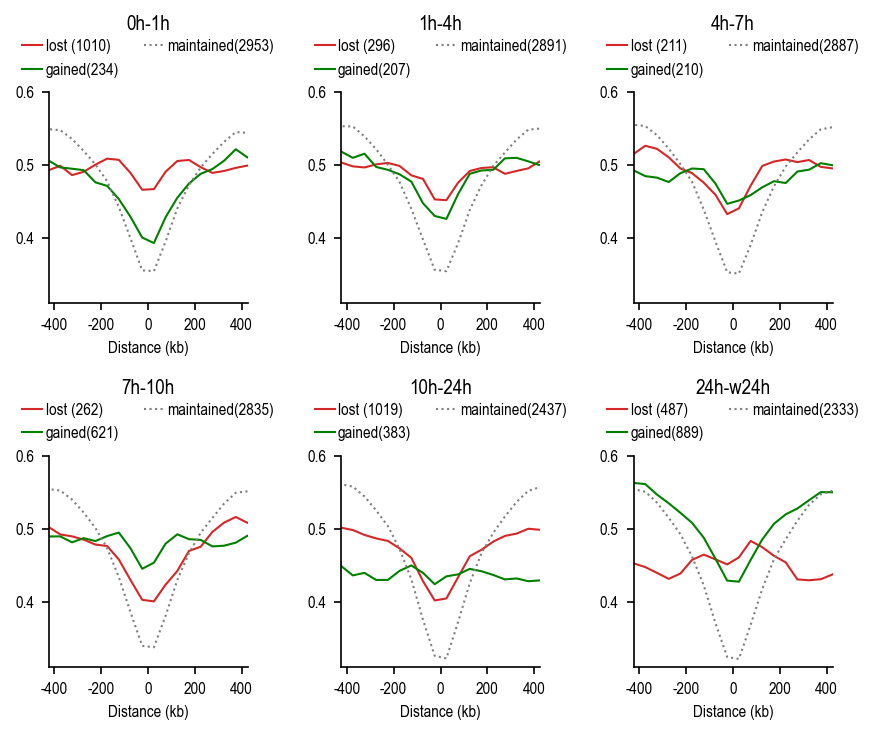

In [36]:
plt.figure(figsize=(6, 5), dpi=150)
for nt, t1 in enumerate(times[:-1]):
    t2 = times[nt + 1]
    tad_lost = tads[(tads[f'score_{t1}'] > 4) & ~(tads[f'score_{t2}'] > 4)]
    lost = get_IS_profile(tad_lost, t1)
    tad_gain = tads[~(tads[f'score_{t1}'] > 4) & (tads[f'score_{t2}'] > 4)]
    gain = get_IS_profile(tad_gain, t2)
    tad_same = tads[(tads[f'score_{t1}'] > 4) & (tads[f'score_{t2}'] > 4)]
    same = (get_IS_profile(tad_same, t1) + get_IS_profile(tad_same, t2)) / 2

    ax = plt.subplot(2, 3, nt + 1)
    plt.title(f"{t1}-{t2}", pad=30, size=10)
    plt.plot(lost, lw=1, label=f'lost ({len(tad_lost)})', color='tab:red')
    plt.plot(gain, lw=1, label=f'gained({len(tad_gain)})', color='green')
    plt.plot(same, lw=1, label=f'maintained({len(tad_same)})', color='tab:grey', ls=":")
    ax.set_xticks([v + 0.5 for v in range(1, 19, 4)])
    ax.set_xticklabels([f"{v * reso // 1000  - 450}" for v in range(1, 19, 4)], fontsize=8)
    ax.set_xlim(1, 18)
    ax.set_xlabel("Distance (kb)", fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(frameon=False, ncol=2, bbox_to_anchor=(0.5, 1), loc='lower center',
              handlelength=1.2, columnspacing=1.5, handletextpad=0.2, fontsize=8)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylim(0.31, 0.6)
plt.tight_layout()
# plt.savefig('Insulation_profile_on_changes.pdf', dpi=300)

# Load PCHiC data

In [43]:
p53 = pd.read_csv('../../data/ComplementaryData/p53bindingsites_annotated.txt', sep='\t')

In [44]:
p53['chr'] = 'chr' + p53['chr'].astype(str)

In [45]:
p53 = p53.rename(columns={'chr': 'chrom'})

In [46]:
import os

In [60]:
ddir = "../../data/ComplementaryData/PCHiC/"

In [68]:
samples = {
    "0h" : {
        "path" : "DMSO_WT_merged_recalibrated2WTDMSO_cutoff_5.ibed",
        "color": (253 / 256, 231 / 256,  36 / 256, 1),
    },
    "1h" : {
        "path" : "Nutlin1h_WT_merged_recalibrated2WTDMSO_cutoff_5.ibed",
        "color": ( 54 / 256, 181 / 256, 120 / 256, 1),
    },
    "1h-degron" : {
        "path" : "Nutlin1h_KD_merged_recalibrated2WTDMSO_cutoff_5.ibed",
        "color": ( 184 / 256, 112 / 256, 112 / 256, 1),
    },
    "10h" : {
        "path" : "Nutlin10h_WT_merged_recalibrated2WTDMSO_cutoff_5.ibed",
        "color": ( 66 / 256,  54 / 256, 126 / 256, 1),
    },
}

In [70]:
datas = {}
for s in samples:
    print(s)
    data = pd.read_csv(os.path.join(ddir, samples[s]["path"]), sep="\t", low_memory=False,
                      names=[
                          'bait_chr', 'bait_start',	'bait_end',	'bait_name', 'otherEnd_chr', 
                          'otherEnd_start', 'otherEnd_end', 'otherEnd_name', 'N_reads', 'score'
                      ])
    # remove P-P
    data = data[data['otherEnd_name'] == '.']
    
    # format
    datas[s] = data[['bait_chr', 'bait_start', 'bait_end', 
                     'otherEnd_chr', 'otherEnd_start',
                     'otherEnd_end']]
    datas[s].drop_duplicates(inplace=True)
    datas[s] = datas[s].astype({
        'bait_chr'      : str,
        'bait_start'    : int, 'bait_end'   : int,
        'otherEnd_chr'  : str,
        'otherEnd_start': int, 'otherEnd_end': int,
    })
    datas[s]['bait_chr']     = 'chr' +  datas[s]['bait_chr']
    datas[s]['otherEnd_chr'] = 'chr' +  datas[s]['otherEnd_chr']

    # remove inter-chromosomes
    datas[s] = datas[s][datas[s]['bait_chr'] == datas[s]['otherEnd_chr']]
    

0h
1h


/tmp/ipykernel_79444/2315895959.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas[s].drop_duplicates(inplace=True)
/tmp/ipykernel_79444/2315895959.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas[s].drop_duplicates(inplace=True)
/tmp/ipykernel_79444/2315895959.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas[s].drop_duplicates(inplace=True)


1h-degron
10h


/tmp/ipykernel_79444/2315895959.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas[s].drop_duplicates(inplace=True)


In [71]:
def reduce_interaction(tmp, offset=5_000, span=5_000):
    tmp0 = tmp.copy()
    tmp0.loc[:,'start'] = tmp.loc[:,['bait_start', 'otherEnd_start']].min(axis=1)
    tmp0.loc[:,'end'  ] = tmp.loc[:,['bait_end', 'otherEnd_end']].max(axis=1)
    tmp0.loc[:,'chrom'] = tmp.loc[:,'bait_chr']
    tmp0 = tmp0[['chrom', 'start', 'end']]
    # reduce window
    tmp0['start'] += offset
    tmp0['end'] -= offset
    # check smallest window is large enough:
    tmp0 = tmp0[(tmp0['end'] - tmp0['start']) > span]
    if (tmp0['end'] - tmp0['start']).min() < span:
        raise Exception((tmp0['end'] - tmp0['start']).min())
    return tmp0


In [72]:
p53["is_functional_Nut1h AND 10h"] = p53["is_functional_Nut1h"] & p53["is_functional_Nut10h"]
p53["is_functional_Nut1h OR 10h"] = p53["is_functional_Nut1h"] | p53["is_functional_Nut10h"]

In [73]:
p53

,chrom,start,end,is_functional,is_functional_Nut1h,is_functional_Nut10h,in_promoter,in_active_promoter,in_enhancer,is_functional_Nut1h AND 10h,is_functional_Nut1h OR 10h
0,chr17,81027504,81027726,True,True,False,False,False,False,False,True
1,chr4,75279228,75279450,False,False,False,False,False,False,False,False
2,chr6,26687121,26687343,True,True,True,False,False,False,True,True
3,chr1,68190934,68191156,True,True,True,False,False,True,True,True
4,chr2,19428605,19428827,True,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
5007,chr11,69811902,69812124,False,False,False,False,False,False,False,False
5008,chr15,22696787,22697009,False,False,False,False,False,False,False,False
5009,chr16,50299255,50299477,True,True,True,False,False,True,True,True
5010,chr21,44229761,44229983,False,False,False,False,False,False,False,False


In [74]:
tmp0 = datas['1h']
tmp1 = datas['10h']
datas['1h AND 10h'] = tmp1.merge(tmp0.drop_duplicates(), 
                                 on=['bait_chr', 'bait_start', 'bait_end', 'otherEnd_chr', 'otherEnd_start', 'otherEnd_end'],
                                 how='inner')
datas['1h OR 10h' ] = tmp1.merge(tmp0.drop_duplicates(), 
                                 on=['bait_chr', 'bait_start', 'bait_end', 'otherEnd_chr', 'otherEnd_start', 'otherEnd_end'],
                                 how='outer')


In [75]:
tads['score_1h AND 10h'] = (tads[['score_1h', 'score_10h']]).apply(lambda x: x.fillna(0).max(), axis=1)
tads['score_1h OR 10h'] = (tads[['score_1h', 'score_10h']]).apply(lambda x: x.fillna(0).min(), axis=1)

## Compute propensity of p53-promoter interaction to break a TAD border

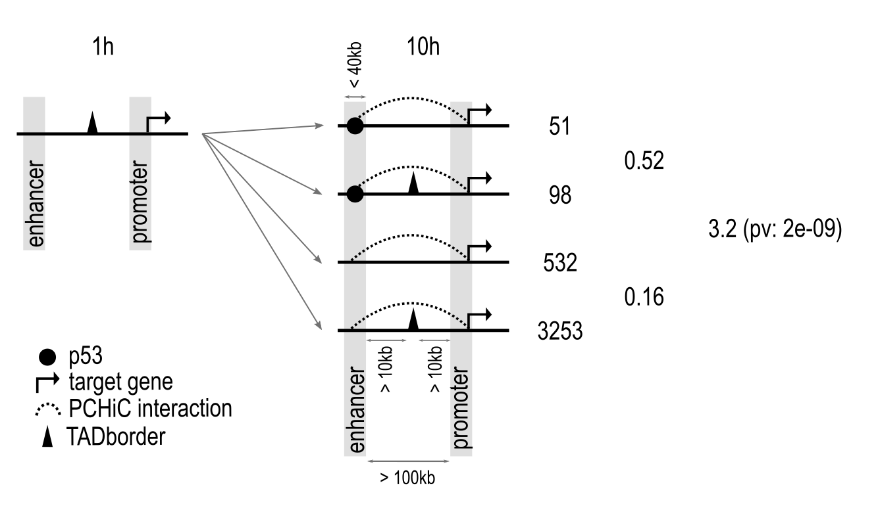

In [76]:
how = "left" # left

for t0, t1 in [('0h', '1h'), ('1h', '10h'), ('0h', '10h'), ('0h', '1h AND 10h'), ('0h', '1h OR 10h')]:
    # get interactions with p53 in enhancer
    tmp0 = datas[t0]
    tmp1 = datas[t1]
    tmp = tmp1.merge(tmp0.drop_duplicates(), 
                     on=['bait_chr', 'bait_start', 'bait_end', 'otherEnd_chr', 'otherEnd_start', 'otherEnd_end'],
                     how=how, indicator=True)
    if how == "left":
        tmp = tmp[tmp['_merge']=='left_only']
    tmp = bf.closest(tmp, p53[p53[f'is_functional_Nut{t1}']], 
                     cols1=['otherEnd_chr', 'otherEnd_start', 'otherEnd_end'])
    # get interactions with enhancer close to a functional p53
    interaction_p53    = tmp[tmp['distance'] < 40_000]
    # get interactions with enhancer far from a functional p53
    interaction_no_p53 = tmp[tmp['distance'] > 100_000]

    ## Define interacting window
    interaction_p53    = reduce_interaction(interaction_p53, offset=10_000, span=100_000)
    interaction_no_p53 = reduce_interaction(interaction_no_p53, offset=10_000, span=100_000)

    # overlap with TADs appearing
    # PCHIC interactions with p53 on the enhancer; inside which we find a TAD border that disappears at 1h
    p53_tad     = sum(bf.closest(interaction_p53   , 
                                 tads[(tads[f'score_{t0}'] > 4) & (tads[f'score_{t1}'] > 4)])['distance'] == 0)
    # PCHIC interactions without p53 on the enhancer; inside which we find a TAD border that disappears at 1h
    nop53_tad   = sum(bf.closest(interaction_no_p53, 
                                 tads[(tads[f'score_{t0}'] > 4) & (tads[f'score_{t1}'] > 4)])['distance'] == 0)
    # PCHIC interactions with p53 on the enhancer; inside which we find a TAD border that remains at 1h
    p53_notad   = sum(bf.closest(interaction_p53   , 
                                 tads[(tads[f'score_{t0}'] > 4) & ~(tads[f'score_{t1}'] > 4)])['distance'] == 0)
    # PCHIC interactions with p53 on the enhancer; inside which we find a TAD border that remains at 1h
    nop53_notad = sum(bf.closest(interaction_no_p53, 
                                 tads[(tads[f'score_{t0}'] > 4) & ~(tads[f'score_{t1}'] > 4)])['distance'] == 0)
    OR, pv = fisher_exact([[p53_notad, p53_tad], [nop53_notad, nop53_tad]])
    print(f" - {t0:>3}  -  {t1:>12}: {OR:.2f} pv:{pv:.2e} "
          f"{[[p53_notad, p53_tad], [nop53_notad, nop53_tad]]} "
          f"{p53_notad/p53_tad:.2f} {nop53_notad/nop53_tad:.2f}")

 -  0h  -            1h: 1.03 pv:8.51e-01 [[126, 152], [1605, 1994]] 0.83 0.80
 -  1h  -           10h: 1.76 pv:4.92e-05 [[85, 281], [468, 2720]] 0.30 0.17
 -  0h  -           10h: 1.04 pv:6.74e-01 [[152, 304], [1321, 2758]] 0.50 0.48
 -  0h  -    1h AND 10h: 0.73 pv:4.91e-01 [[10, 34], [195, 484]] 0.29 0.40
 -  0h  -     1h OR 10h: 0.99 pv:9.13e-01 [[415, 436], [3255, 3389]] 0.95 0.96
